# How does a neural network work

Machine learning models are things(for lack of a better word) that fit functions to data.

A neural net consists of many layers of mathematical functions that:  
- multiplies inputs by a given value(also known as parameters)
- adds them to each group of value
- replaces the negative numbers with zero  

This is repeated across all layers, whereby the output of one layer is the input of the next layer. However, this doesn't do anything useful.

To allow this functions to 'learn' to perform a task, we have to change the parameters depending on the task. This is achieved using Gradient Descent.

The following illustrates how it works:

## Fitting a Quadratic

We will use a quadratic function as an illustration.

In [1]:
from fastai.basics import *
plt.rc('figure', dpi=90)
def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x=torch.linspace(min, max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

This lines of code above shows how we achieve the ploting that will be used in this notebook.

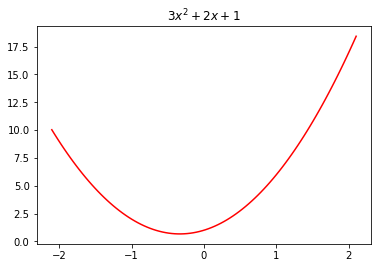

In [2]:
def f(x): return 3*x**2 + 2*x +1
plot_function(f, "$3x^2 + 2x + 1$")

The quadratic here is in the form ax^2 + bx + c, with parameters a=3, b=2, and c=1.  
The writing between the $(latex) shows how we can create kind of typeset mathematical equations.

## Create Different Quadratics

Assuming, we were not given the parameters, we can try different quadratic that creates a function that calculates the value of point on a quadratic.

In [3]:
def quad(a, b, c, x): return a*x**2 + b*x + c

If we assign 3, 2, 1 to a, b, c , respectively and fix 1.5 as the value of x using the code:  
quad(3, 2, 1, 1.5)  
As seen in the commented cell below gives us an output of 10.75.

In [4]:
#quad(3, 2, 1, 1.5)

Remember, we don't have the values of the parameters therefore we have find them.

In [5]:
from functools import partial
def mk_quad(a, b, c): return partial(quad, a, b, c)

Partial allows us to use the quad function but fix the values of a, b, c to pick particular values.  
For example:

In [6]:
#f=mk_quad(3, 2, 1)
#f(1.5)

This creates a quadratic equation with coefficients 3, 2, 1 and gets 10.75.

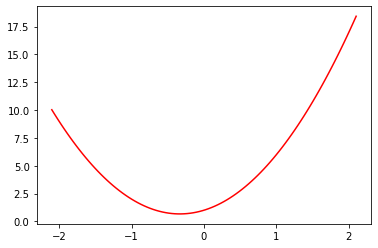

In [7]:
plot_function(f)

## Add Noise

In real life, data is never going to match the shape of a function. For this reason, we will add some random noise to the data.  
We will then use gradient descent to see if we can recreate the original function from the data.

In [8]:
from numpy.random import normal, seed, uniform
np.random.seed(42)
def noise (x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1 + noise(x, mult)) + noise(x, add)

In [9]:
x = torch.linspace(-2, 2, steps = 20)[:,None]
y = add_noise(f(x), 0.3, 1.5)

Explaining a few functions used:  
normal -> creates normally distributed random numbers  
random.seed -> shows how we set the seed so that every time we run the code we get the same random number  
torch.linspace -> creates a tensor, so that in this case we get a vector that goes from -2 to 2 in equal steps and there are 20 of them (steps = 20)  
y -> is just f(x), the amount of noise addded

In [10]:
x[:5], y[:5]

(tensor([[-2.0000],
         [-1.7895],
         [-1.5789],
         [-1.3684],
         [-1.1579]]),
 tensor([[12.5396],
         [ 6.3975],
         [ 6.4566],
         [ 3.5170],
         [ 1.6997]], dtype=torch.float64))

These are a few values of x and y in tensor form.  

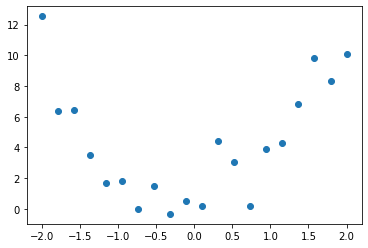

In [11]:
plt.scatter(x, y);

## Reconstructing the original quadratic equation

Now that we have random values, we need to find the values of a, b, c that match the data. We can do this by trying a few values and see the ones that fit.

In [12]:
from ipywidgets import interact
@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a, b, c):
    plt.scatter(x, y)
    plot_function(mk_quad(a, b, c), ylim=(-3,12))

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

interact allows us to have an interactive feature to our function by adding sliders.  
Using the slider to the left or right for the values of a, b, c helps us find the best fit of the quadratic to the data.

However, this is not the most efficient method to find the values. We need to find a measure that tells us whether our model is getting better or worse. This can be achieved numerically by calculating the mean squared error.  
Mean Squared Error -> the distance between each data point to the curve.

In [13]:
def mse(preds, acts): return((preds - acts)**2).mean()

This is a loss function.  
mse function gets predictions and actuals  
It returns the square of predictions - actuals, then calculates the mean.

In [14]:
@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a, b, c):
    f=mk_quad(a, b, c)
    plt.scatter(x, y)
    loss=mse(f(x), y)
    plot_function(f, ylim=(-3, 12), title = f"MSE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

We calculate the loss(mse) between the values that we predict(f(x)); where f is the quadratic we created and y is the actuals.

Moving the interact slides to the left or right for the values of a, b, c allows us to see where the loss (MSE) is getting better or worse.

## Automating the gradient descent process

Neural networks have millions of parameters therefore moving the interact slide for each parameter is not the most efficient way to check if the loss is getting better or worse.

This can be achieved by calculating the derivative.  
Derivative -> function that tells you whether the increase an input increases or decreases the output, and by how much. This is called the gradient/slope.

If we know the gradient of our mse(mean squared error) with respect to our values a, b, c, then we will know how to adjust the values a, b, and c. That is, whether to increase or decrease them.

We will find the gradient of the mse() of each parameter then adjust it in the opposite direction of the sign of the gradient.  
For instance, if the gradient sign is negative, we will increase the value. If the gadient sign is positive, we will reduce the value.

In [15]:
def quad_mse(params):
    f=mk_quad(*params)
    return mse(f(x), y)

First, we need a function that takes the coefficients of the quadratic a, b, c as inputs.  
(*) -> takes these parameters and spreads them out to turn them into a, b, c and pass them to the function.  


The function returns the mean squared error of our predictions against our actuals.  
It takes the coefficients of the quadratic and returns the loss.

In [16]:
quad_mse([1.5, 1.5, 1.5])

tensor(5.8336, dtype=torch.float64)

Here, we get a mse of 5.8336 just like in the plot above.

A tensor is like an array in numpy. It doesn't work with numbers only, it also works with lists or vectors of numbers.

First, we are going to manually pick some arbitrary starting points for our starting point and put it in a single tensor or rank-1 tensor.

In [17]:
abc = torch.tensor([1.5, 1.5, 1.5])
abc.requires_grad_()

tensor([1.5000, 1.5000, 1.5000], requires_grad=True)

To calculate the gradient for these numbers, we need to call requires_grad_()

In [18]:
loss = quad_mse(abc)
loss

tensor(5.8336, dtype=torch.float64, grad_fn=<MeanBackward0>)

We can now calculate mse by passing quad_mse which is the function that gets the mean squared error for a set of coeffiecients.

From the output, grad_fn tells us that Pytorch knows how to calculate the gradient for our inputs.

To give Pytorch a go ahead to do the calculation, we call 'backward' on the results of the loss function.

In [19]:
loss.backward()

We don't get an output from this, rather we just added an attribute called grad, which is the gradient to our input 'abc'.

In [20]:
abc.grad

tensor([-5.1419,  2.8472, -1.1009])

The results of this gradients mean that:  
-> if we increase a, the loss will reduce  
-> if we decrease b, the loss will reduce  
-> if we increase c, the loss will reduce

In [21]:
with torch.no_grad():
    abc -= abc.grad*0.01
    loss = quad_mse(abc)
    
print(f'loss={loss:.2f}')

loss=5.49


The above code lets us subtract the gradient then multiply it by a small number to reduce the loss.  
The small number in our case is 0.01 which is also referred to as the learning rate. This is an important hyperparameter to set when traing a neural network.

with torch.no_grad() means we don't want to calculate the gradient before we change the gradient from the new parameters.

-= means abc minus the gradient then decrease it a bit by 0.01.  
This will create a new set of parameters(abc) which are a bit bigger than before as we subtracted the negative numbers.  

Then we calculate the loss again. We get a loss of 5.49 which is better than the previous 5.83.

## Automating the process

In [22]:
for i in range(5):
    loss = quad_mse(abc)
    loss.backward()
    with torch.no_grad(): abc -= abc.grad*0.01
    print(f'step={i}; loss={loss:2f}')

step=0; loss=5.489318
step=1; loss=4.900367
step=2; loss=4.233165
step=3; loss=3.666485
step=4; loss=3.334242


This allows us to iterate over the process 5 times. As you can see, the loss decreases with every iteration. this is called Optimization.
Optimization is built on the principle of gradient descent, whereby we calculate the gradient then do a descent(minimize the loss).

## Approximating any given value

A neural network is an expressive function and can calculate any computable function given the parameters.

It is able to compute any function through two simple steps:  
 (i) Matrix multiplication, multiplying values then adding them together.  
 (ii) The function max(x, 0) which simply replaces negative numbers with zero.

In Pytorch, max(x, 0) is wriiten as np.clip(x, 0).

The combination of a linear function with max() is called Rectified Linear function.  
It can be expressed as:

In [23]:
def rectified_linear(m, b, x):
    y = m*x + b
    return torch.clip(y, 0.)

torch.clip() is a function that takes the output, y, and if it is smaller than the number, it turns it into the number.
In our case, it checks the value of y, and if its negative it turns it to a zero.

So the rectified_linear() function calculates the output of a line then checks if it is smaller than zero so as to convert the value to zero.

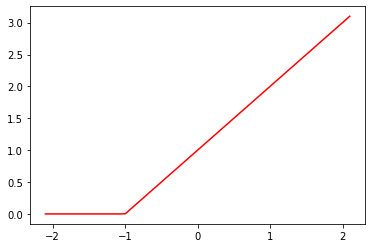

In [24]:
plot_function(partial(rectified_linear, 1, 1))

Instead of torch.clip(y, 0.), we can instead use F.relu(x), which does exactly the same thing. In PyTorch, F refers to the torch.nn.functional module.

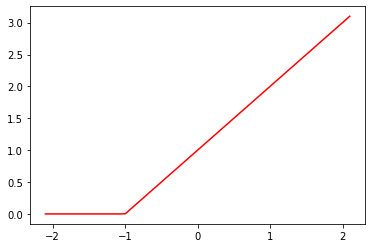

In [25]:
import torch.nn.functional as F
def rectified_linear2(m,b,x): return F.relu(m*x+b)
plot_function(partial(rectified_linear2, 1,1))

We use 'partial'  to take the function and set m and b to 1 and 1.

partial(rectified_linear, 1, 1) will be y when passed to torch.clip().

Adding the interact:

In [26]:
@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, m, b), ylim=(-1, 4))

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

ylim -> limits on the y axis  
m -> slope, b -> intercept with a shift up and down / the location.

## Creating a double Rectified Linear Unit(ReLU)

Lets try add two rectified linear functions together.

In [27]:
def double_relu(m1, b1, m2, b2, x):
    return rectified_linear(m1, b1,x) + rectified_linear(m2, b2, x)

In [28]:
@interact(m1 = -1.5, b1 = -1.5, m2 = 1.5, b2 = 1.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1, b1, m2, b2), ylim = (-1, 6))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

We can add as many rectified linear functions as we want.